# Landscape Generation

## Environment Configuration

### Install Dependencies

In [1]:
!apt-get update
!apt-get -y install graphviz
!pip install matplotlib
!pip install opendatasets
!pip install pandas
!pip install tensorflow-datasets
!pip install pydot

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1581 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [591 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]      
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1392 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1419 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [49.9 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1013 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1279 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-

### Show Dependencies

In [2]:
# help("modules")

### Import Dependencies

#### General

In [3]:
from datetime import datetime
from functools import reduce
from matplotlib import pyplot as plt
import numpy as np
import opendatasets as od
import os
import pandas as pd
import time

#### Tensorflow

In [4]:
def tf_set_gpu_memory_growth():
    """Avoid preemptively filling all GPU memory"""
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)

In [5]:
import tensorflow as tf

os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"
tf.debugging.set_log_device_placement(True) 

print("Physical GPUs Available:", tf.config.list_physical_devices('GPU'))
print("Logical GPUs Available:", tf.config.list_logical_devices('GPU'))
print("GPU Used:", tf.test.gpu_device_name())
print("GPU Support:", tf.test.is_built_with_gpu_support())
print("Cuda:", tf.test.is_built_with_cuda())
print("ROCm:", tf.test.is_built_with_rocm())
print("XLA", tf.test.is_built_with_xla())

# tf_set_gpu_memory_growth()

import tensorflow.keras as keras
from tensorflow.keras import backend as K
import keras.layers as layers
import tensorflow_datasets as tfds

2023-11-03 09:09:41.763111: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 09:09:41.957694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 09:09:41.957725: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 09:09:41.958544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 09:09:42.046827: I tensorflow/core/platform/cpu_feature_g

Physical GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical GPUs Available: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Used: /device:GPU:0
GPU Support: True
Cuda: True
ROCm: False
XLA True


#### Specification

In [6]:
!nvidia-smi
# !nvidia-smi -q

Fri Nov  3 09:09:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.120                Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 ...    On  | 00000000:01:00.0  On |                  N/A |
| N/A   41C    P0              35W / 150W |   1116MiB / 16384MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Download Dataset

In [7]:
# Do only the first time (requires kaggle credentials: username, api-token)
# od.download("https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images")

In [8]:
def indexFiles(path, moveTo = None, i = 0):
    """Renames all files in the specified directory to an increasing index.
    
    Description:
    Renames all files inside the 'path' directory to an increasing index,
    starting from 'i', eventually moving them to the 'moveTo' directory.
    """
    if moveTo is None: moveTo = path
    for filename in os.listdir(path):
        name, extension = os.path.splitext(filename)
        os.rename(path + "/" + filename, moveTo + "/" + str(i) + extension)
        i += 1

In [9]:
download_directory = "./landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/TFrecords/"
dataset_directory = "./dataset"

# indexFiles(path = download_directory + "Train", moveTo = dataset_directory, i = 0)
# indexFiles(path = download_directory + "Valid", moveTo = dataset_directory, i = 10000)
# indexFiles(path = download_directory + "Test", moveTo = dataset_directory, i = 11500)

## Utilities

In [10]:
def log(*args):
    """Print the specified sequence of objects."""
    prefix = ["[" + str(datetime.utcnow()) + "]:"]
    print(*(prefix + [*args]))

## Preprocessing

### Load Dataset

In [11]:
dataset_files = list(map(lambda f: os.path.join(dataset_directory, f), os.listdir(dataset_directory)))
dataset = tf.data.TFRecordDataset(dataset_files)
dataset_size = len(dataset_files)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0


2023-11-03 09:09:46.702746: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:46.702779: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:46.702783: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0


Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Reshape in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0


2023-11-03 09:09:46.964809: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:46.964963: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:46.964969: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:46.971559: I tensorflow/core/common_runtime/placer.cc:125] tensor: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:46.971595: I tensorflow/core/common_runtime/placer.cc:125] shape: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:46.971601: I tensorflow/core/common_runtime/placer.cc:125] Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:46.971604: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2

In [12]:
dataset = dataset.shuffle(buffer_size = dataset_size)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0


2023-11-03 09:09:47.008781: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:47.008824: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:47.008828: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:47.101512: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.101546: I tensorflow/core/common_runtime/placer.cc:125] DummySeedGenerator: (DummySeedGenerator): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.106179: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.106219: I tensorflow/core/common_runtime/placer.cc:125] buffer__size: (_Arg): /job:localhost/

### Preprocess Dataset

In [13]:
features = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
}

labels = { 0: 'Coast', 1: 'Desert', 2: 'Forest', 3: 'Glacier', 4: 'Mountain', }

def preprocess_record(record):
    """Decode the specified raw TFRecord into a pair of (object, label)"""
    parsed_record = tf.io.parse_single_example(record, features)
    return (parsed_record['image'], parsed_record['label'])

def decode_and_crop_image(xi, yi):
    """Decode the specified string image to JPEG and crop it to size '256x256x3'"""
    return (tf.image.decode_and_crop_jpeg(xi, crop_window=[0,0,256,256], channels=3), yi)

def resize_image(xi, yi):
    """Decode the specified string image to JPEG and crop it to size '256x256x3'"""
    return (tf.image.resize(xi, size=(64,64), method=ResizeMethod.BILINEAR), yi)

def normalize_image(xi, yi):
    """Normalize the specified image from the space [0..255]*[0..255]*[0..255] to the space [0..1]*[0..1]*[0..1]"""
    return (tf.cast(xi, tf.float32) / 255, yi)
    
def label_to_one_hot_encoding(xi, yi):
    """Encode the specified label using one-hot-encoding"""
    return (xi, tf.one_hot(yi, len(labels)))

def one_hot_encoding_to_label_name(yi):
    """Decode one-hot-encoding labels to their corresponding human-friendly name"""
    return labels[tf.argmax(yi).numpy()]

In [14]:
dataset = dataset.shuffle(buffer_size = dataset_size)
dataset = dataset.map(preprocess_record, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(decode_and_crop_image, num_parallel_calls=tf.data.AUTOTUNE)
# dataset = dataset.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(label_to_one_hot_encoding, num_parallel_calls=tf.data.AUTOTUNE)
# dataset = dataset.cache(filename = "./cache/dataset")

Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


2023-11-03 09:09:47.166829: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.166864: I tensorflow/core/common_runtime/placer.cc:125] num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.166872: I tensorflow/core/common_runtime/placer.cc:125] ParallelMapDatasetV2: (ParallelMapDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.166874: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


2023-11-03 09:09:47.191501: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.191548: I tensorflow/core/common_runtime/placer.cc:125] num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.191556: I tensorflow/core/common_runtime/placer.cc:125] ParallelMapDatasetV2: (ParallelMapDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.191559: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.216064: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.216119: I tensorflow/core/common_runtime/placer.cc:125] num__parallel__calls: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.216127: I tensorflow/core/common_runtime/placer.cc:125] ParallelMapDataset

### Visualize Dataset

In [15]:
for ([x0, y0]) in dataset.take(1):
    log("Object Shape:", x0.shape)
    log("Label Shape:", y0.shape)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0


2023-11-03 09:09:47.250116: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.250153: I tensorflow/core/common_runtime/placer.cc:125] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.250161: I tensorflow/core/common_runtime/placer.cc:125] TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.250165: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.252565: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.252604: I tensorflow/core/common_runtime/placer.cc:125] AnonymousIteratorV3: (AnonymousIteratorV3): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.254326: I tensorflow/core/common_runtime/placer.cc:125] dataset: (_Arg): /job:localhost/rep

input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
input: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
_EagerConst: (_EagerConst): /job:localhost/replica:0/task:0/device:GPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
tensor: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
shape: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
Reshape: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
TensorSliceDataset: (TensorSliceDataset): /job:localhost/replica:0/task:0/device:CPU:0
handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
FlatMapDataset: (FlatMapDataset): /

2023-11-03 09:09:47.300974: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.301019: I tensorflow/core/common_runtime/placer.cc:125] args_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.301026: I tensorflow/core/common_runtime/placer.cc:125] DecodeAndCropJpeg: (DecodeAndCropJpeg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.301030: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.301033: I tensorflow/core/common_runtime/placer.cc:125] Identity_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.301036: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:47.301038: I tensorflow/core/common_runtime/placer.cc:125] FakeSink1: (Identity): /job:localhost/replica:0/task:0/de

[2023-11-03 09:09:50.938960]: Object Shape: (256, 256, 3)
[2023-11-03 09:09:50.939925]: Label Shape: (5,)
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0


Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
ca:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
identity_1_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/Const_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/ParseExampleV2/names: (Const): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/ParseExampleV2/sparse_keys: (Const): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/ParseExampleV2/dense_keys: (Const): /job:localhost/replica:0/task:0/device:CPU:0

2023-11-03 09:09:50.975381: I tensorflow/core/common_runtime/placer.cc:125] args_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:50.975416: I tensorflow/core/common_runtime/placer.cc:125] ParseSingleExample/ParseExample/ParseExampleV2: (ParseExampleV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:50.975421: I tensorflow/core/common_runtime/placer.cc:125] Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:50.975423: I tensorflow/core/common_runtime/placer.cc:125] Identity_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:50.975426: I tensorflow/core/common_runtime/placer.cc:125] FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:50.975428: I tensorflow/core/common_runtime/placer.cc:125] FakeSink1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:50.975430: I tensorflow/core/common_runtime/placer.cc:125] identity_RetVal: (_Retva

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
task:0/device:CPU:0
ParseSingleExample/ParseExample/ParseExampleV2: (ParseExampleV2): /job:localhost/replica:0/task:0/device:CPU:0
Identity: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Identity_1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink0: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
FakeSink1: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
identity_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
identity_1_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/Const_1: (Const): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/ParseExampleV2/names: (Const): /job:localhost/replica:0/task:0/device:CPU:0
ParseSingleExample/ParseExample/ParseExampleV2/sparse_keys: (Const): /job

2023-11-03 09:09:55.006987: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:55.007029: I tensorflow/core/common_runtime/placer.cc:125] dimension: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:55.007035: I tensorflow/core/common_runtime/placer.cc:125] ArgMax: (ArgMax): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:55.007037: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0


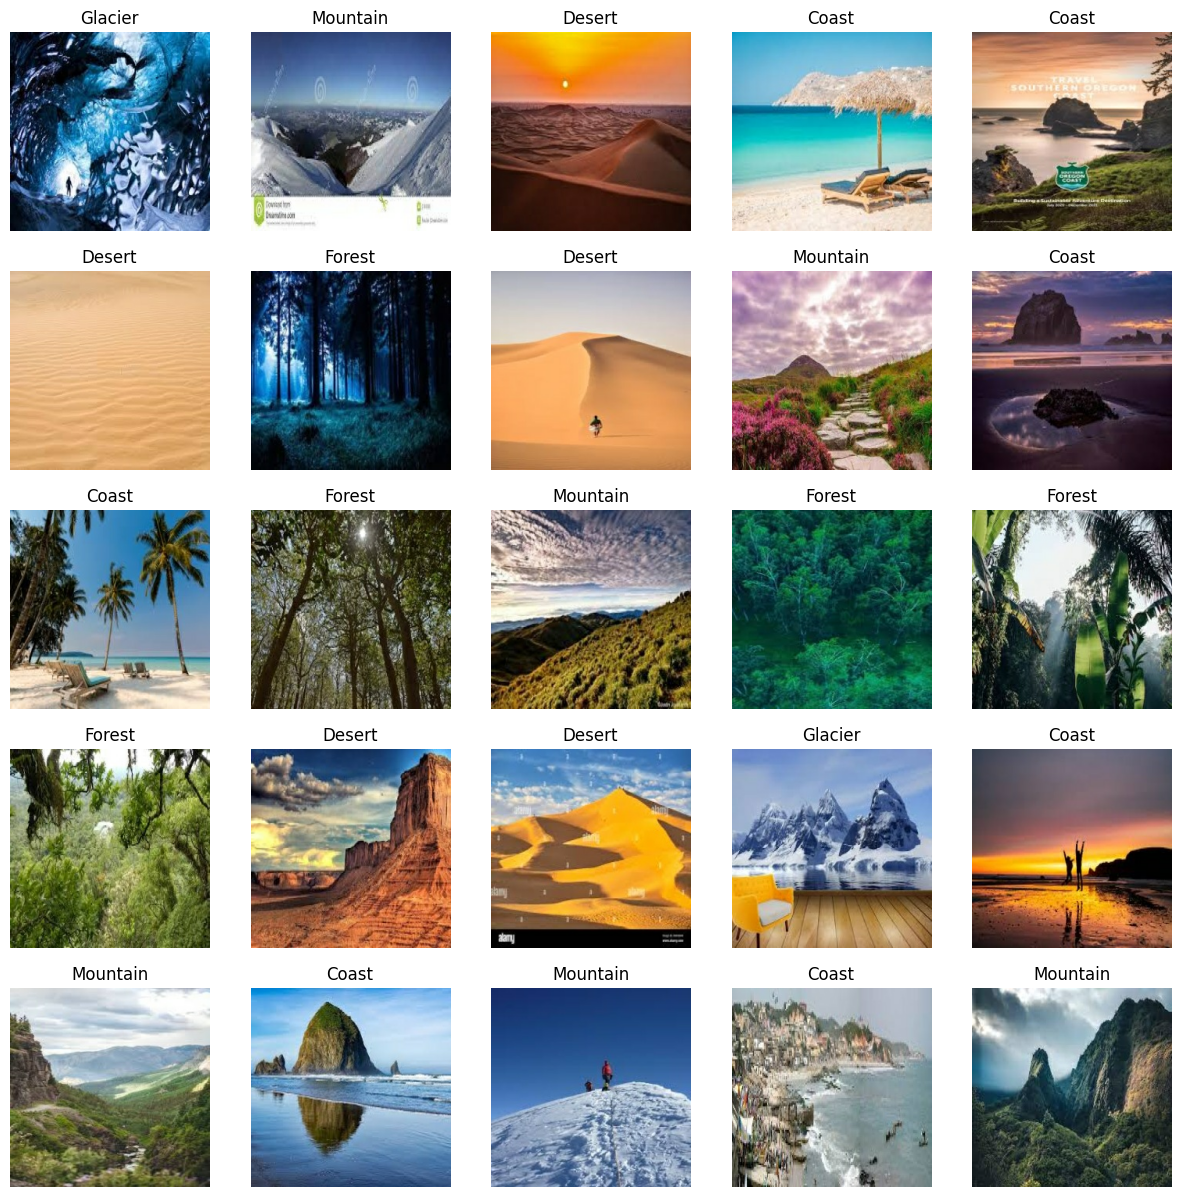

In [16]:
def show_dataset_sample(dataset, n_rows = 5, n_cols = 5, figsize = None):
    """Display a grid of a number of samples from 'dataset' equals to 'n_rows*n_cols'."""
    if figsize == None: figsize = (15, 3*n_rows)
    xys = iter(dataset)
    fig, axs = plt.subplots(n_rows, n_cols, figsize = figsize)
    for row in range(0, n_rows):
        for col in range(0, n_cols):
            [xi, yi] = next(xys)
            axs[row, col].imshow(xi)
            axs[row, col].title.set_text(one_hot_encoding_to_label_name(yi))
            axs[row, col].axis('off')

show_dataset_sample(dataset)

## Model Definition

### Configuration

In [17]:
features = 256                      # Number of features extracted from the images 
condition_size = 5                  # Size of the condition (possible classes of the input)
code_size = 10                      # Size of the code in the latent space
hidden_layers = [256, 256, 256]     # Hidden layers in the encoder and decoder
hidden_activation = 'sigmoid'       # Activation function of the hidden layers in the encoder and decoder
output_activation = 'sigmoid'       # Activation function of the output layer of the decoder

### Convolutional Encoder

In [18]:
convolutional_encoder = keras.Sequential(
    layers = [
        layers.Input(name='CE_I', shape=(256, 256, 3)),
        
        layers.Conv2D(name='CE_C0', filters=32, kernel_size=(16,16), strides=4, padding='valid', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Conv2D(name='CE_C1', filters=64, kernel_size=(7,7), strides=2, padding='valid', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),

        layers.Conv2D(name='CE_C2', filters=128, kernel_size=(4,4), strides=2, padding='valid', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.Conv2D(name='CE_C3', filters=256, kernel_size=(3,3), strides=2, padding='valid', activation="relu"),
        layers.Conv2D(name='CE_C4', filters=256, kernel_size=(4,4), strides=2, padding='valid', activation="relu"),

        layers.Flatten(),
        layers.Dense(name='CE_O', units=features, activation='relu'),
    ],
    name = "ConvolutionalEncoder"
)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executin

2023-11-03 09:09:56.369055: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:56.369118: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:56.371864: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:56.371903: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:56.371911: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:56.380553: I tensorflow/core/common_runtime/placer.cc:125] input: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:56.380600: I tensorflow/core/common_runtime/placer.cc:125] _EagerConst: (_EagerConst): /job:localhost/replica:0/tas

Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:

2023-11-03 09:09:57.280128: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.280173: I tensorflow/core/common_runtime/placer.cc:125] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.280179: I tensorflow/core/common_runtime/placer.cc:125] Mul: (Mul): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.280182: I tensorflow/core/common_runtime/placer.cc:125] z_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.310259: I tensorflow/core/common_runtime/placer.cc:125] x: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.310301: I tensorflow/core/common_runtime/placer.cc:125] y: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.310308: I tensorflow/core/common_runtime/placer.cc:125] AddV2: (AddV2): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.310310: I tensorflow/core/common_runtime

Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localh

2023-11-03 09:09:57.511639: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.511713: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.513180: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.513216: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.513223: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.516681: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.516720: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

### Convolutional Decoder

In [19]:
convolutional_decoder = keras.Sequential(
    layers = [
        layers.Input(name='CD_I', shape=features),
        layers.Dense(name='CD_H', units=1024),
        layers.Reshape(name='CD_R', target_shape=(2, 2, 256)),

        layers.Conv2DTranspose(name='CD_TC4', filters=256, kernel_size=(4,4), strides=2, padding='valid', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.Conv2DTranspose(name='CD_TC3', filters=128, kernel_size=(3,3), strides=2, padding='valid', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.Conv2DTranspose(name='CD_TC2', filters=64, kernel_size=(4,4), strides=2, padding='valid', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        
        layers.Conv2DTranspose(name='CD_TC1', filters=32, kernel_size=(7,7), strides=2, padding='valid', activation="relu"),
        layers.Conv2DTranspose(name='CD_TC0', filters=3, kernel_size=(16,16), strides=4, padding='valid', activation="relu"),
    ],
    name = "ConvolutionalDecoder"
)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing o

2023-11-03 09:09:57.609054: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.609095: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.610473: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.610511: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.610518: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.613963: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.614010: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in d

2023-11-03 09:09:57.797890: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.797946: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.799827: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.799870: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.799878: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0


### Encoder

In [20]:
condition_input = layers.Input(name='Condition', shape=(condition_size,))
encoder_input = layers.Concatenate(name='E_I')([convolutional_encoder.output, condition_input])

i = 0
prev_layer = encoder_input
for neuron_count in hidden_layers:
    hidden_layer = layers.Dense(name='E_H'+str(i), units=neuron_count, activation=hidden_activation)(prev_layer)
    prev_layer = hidden_layer
    i = i + 1

mean = layers.Dense(name='E_O_Mean', units=code_size)(prev_layer)
log_variance = layers.Dense(name='E_O_LogVariance', units=code_size)(prev_layer)

encoder = keras.Model(name='Encoder', inputs=[convolutional_encoder.input, condition_input], outputs=[mean, log_variance])

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device

2023-11-03 09:09:57.837220: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.837262: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.839083: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.839139: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.839147: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.858071: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.858173: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/

### Decoder

In [21]:
decoder_code_input = layers.Input(name='D_I_Code', shape=(code_size,))
decoder_input = layers.Concatenate(name='D_I')([decoder_code_input, condition_input])

i = 0
prev_layer = decoder_input
for neuron_count in reversed(hidden_layers):
    hidden_layer = layers.Dense(name='D_H'+str(i), units=neuron_count, activation=hidden_activation)(prev_layer)
    prev_layer = hidden_layer
    i = i + 1

decoder_output = layers.Dense(name='D_O', units=features, activation=output_activation)(prev_layer)
decoder = keras.Model(name='Decoder', inputs=[decoder_code_input, condition_input], outputs=convolutional_decoder(decoder_output))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device

2023-11-03 09:09:57.957765: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.957813: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.959343: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.959375: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:57.959381: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0


Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in d

### Conditional Variational AutoEncoder (CVAE)

In [22]:
def sampling(args):
    mean, log_variance = args
    batch_size = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch_size, dim), mean=0., stddev=1.0)
    return K.exp(0.5 * log_variance) * epsilon + mean
sampling = layers.Lambda(name='Sampling', function=sampling, output_shape=(code_size,))([mean, log_variance])

In [23]:
cvae = keras.Model(name='CVAE', inputs=encoder.input, outputs=decoder([sampling, condition_input]))    

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [24]:
cvae.summary()

Model: "CVAE"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 CE_I (InputLayer)           [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 CE_C0 (Conv2D)              (None, 61, 61, 32)           24608     ['CE_I[0][0]']                
                                                                                                  
 batch_normalization (Batch  (None, 61, 61, 32)           128       ['CE_C0[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 61, 61, 32)           0         ['batch_normalization[0][0]

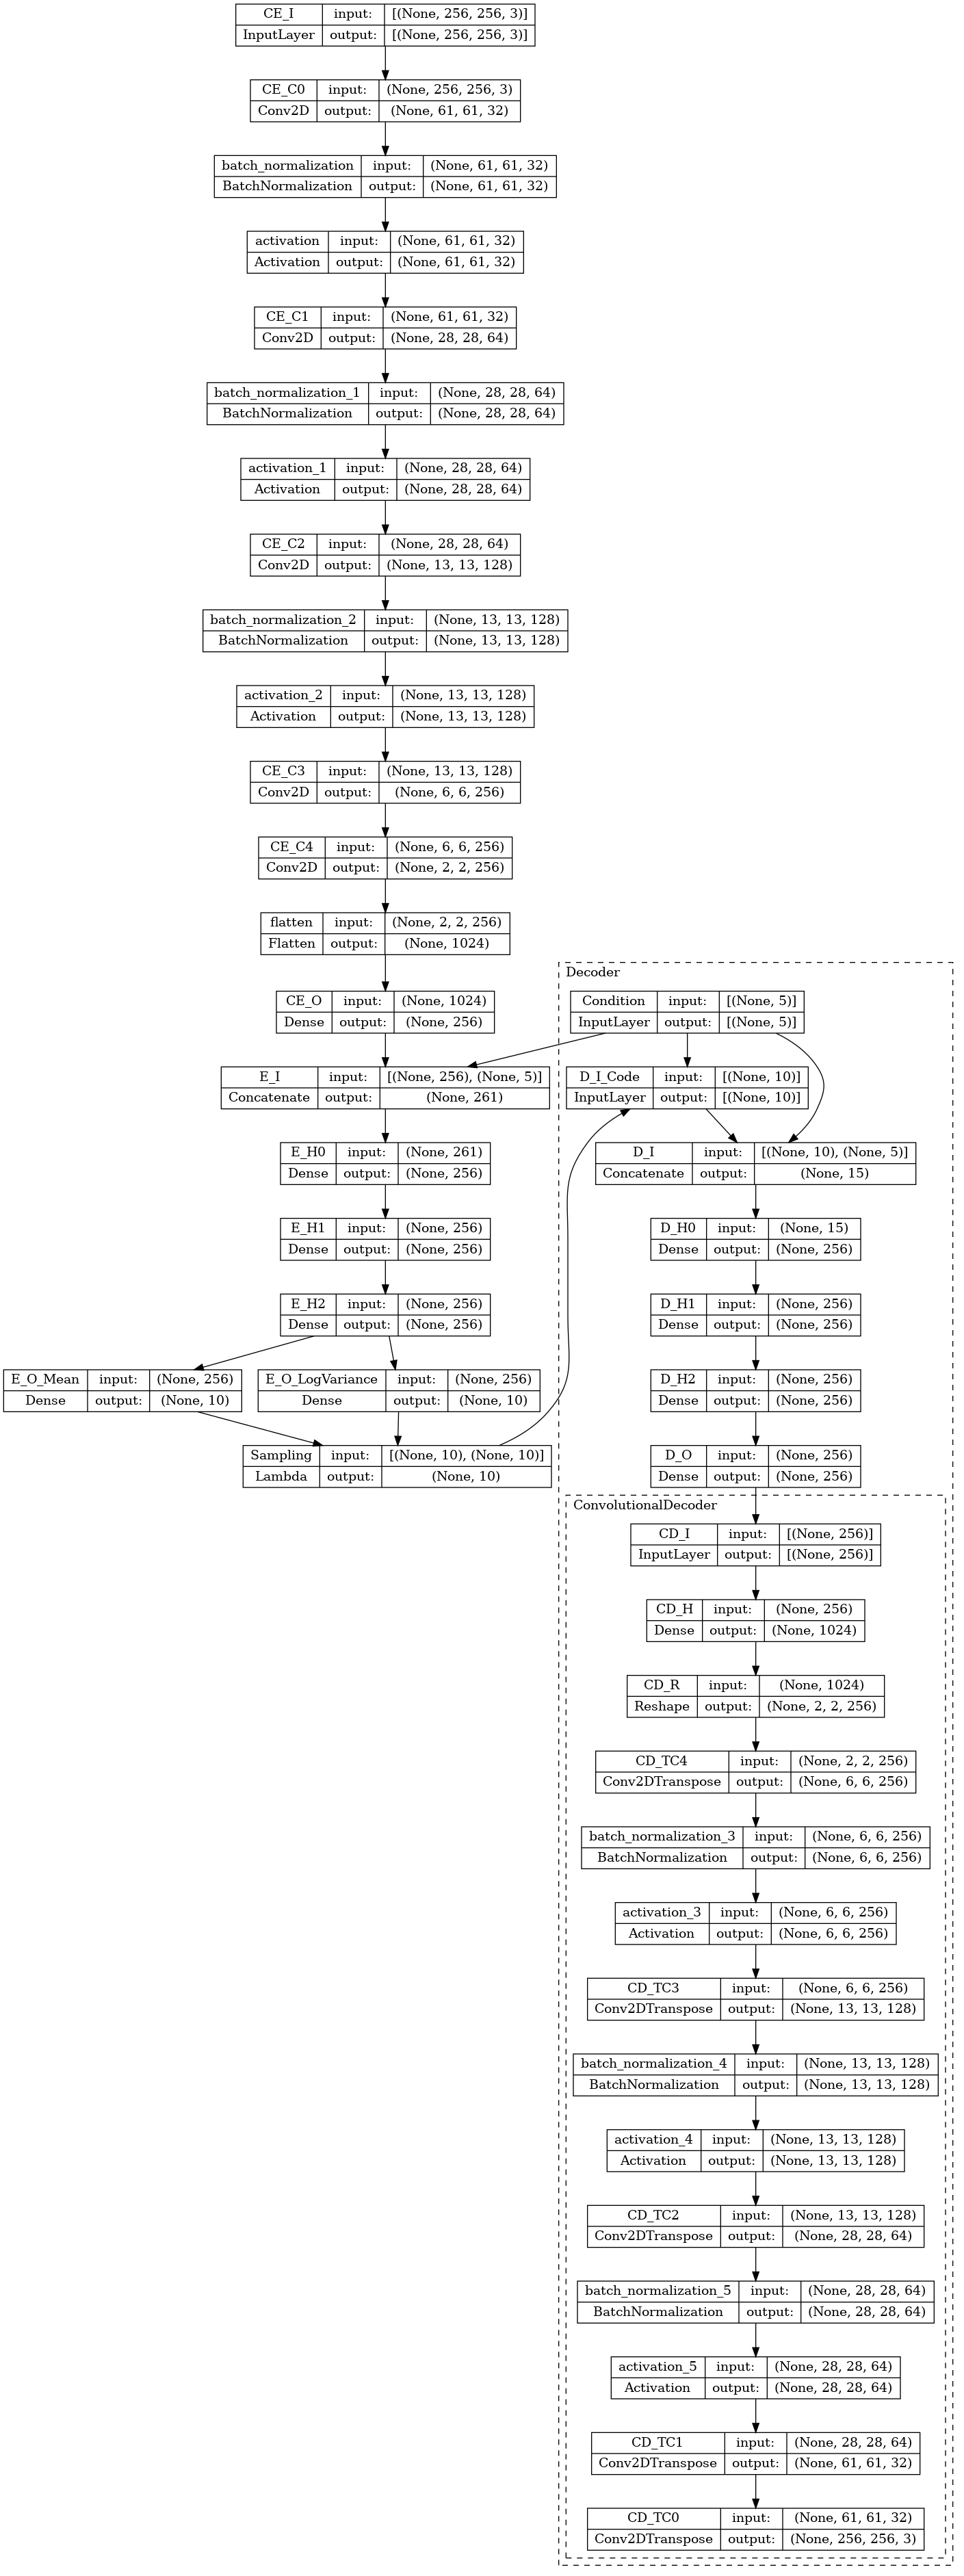

In [25]:
keras.utils.plot_model(cvae, show_shapes=True, show_layer_names=True, expand_nested=True)

## Training

### Configuration

In [26]:
train_size = int(0.7 * dataset_size)
validation_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)

shuffle_buffer_size = 256
batch_size = 64
epoch_count = 100
patience = 5
KL_coefficient = 1
optimizer = keras.optimizers.Adam(learning_rate = 0.001)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


2023-11-03 09:09:58.576306: I tensorflow/core/common_runtime/placer.cc:125] resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:58.576339: I tensorflow/core/common_runtime/placer.cc:125] VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:58.581825: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:58.581865: I tensorflow/core/common_runtime/placer.cc:125] value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:58.581874: I tensorflow/core/common_runtime/placer.cc:125] AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0


In [27]:
log("Training Set Size:", train_size)
log("Validation Set Size:", validation_size)
log("Test Set Size:", test_size)

[2023-11-03 09:09:58.589542]: Training Set Size: 8400
[2023-11-03 09:09:58.589739]: Validation Set Size: 1800
[2023-11-03 09:09:58.589772]: Test Set Size: 1800


### Loss Function

In [51]:
def reconstruction_error(input, output, dataset_size):
    input_flatten = tf.reshape(input, shape=(-1, tf.size(input)))
    output_flatten = tf.reshape(output, shape=(-1, tf.size(output)))
    return dataset_size * keras.losses.mean_squared_error(input_flatten, output_flatten)

def regularization_error(mean, log_variance, KL_coefficient):
    return KL_coefficient * (0.5 * K.sum(K.square(mean) + K.exp(log_variance) - log_variance - 1, axis = -1))
    
def loss(input, output, dataset_size, mean, log_variance, KL_coefficient):
    return reconstruction_error(input, output, dataset_size) + regularization_error(mean, log_variance, KL_coefficient)

In [52]:
cvae.add_loss(
    loss(
        input=cvae.input[0],
        output=cvae.output,
        dataset_size=dataset_size,
        mean=cvae.get_layer('E_O_Mean').output,
        log_variance=cvae.get_layer('E_O_LogVariance').output,
        KL_coefficient=KL_coefficient,
    )
)

TypeError: unhashable type: 'DictWrapper'

### Callbacks

#### Image Generation Callback

In [30]:
class GenerateImageSample(keras.callbacks.Callback):
    def __init__(self,
        image_types = tf.one_hot(tf.constant(list(labels.keys())), len(labels)),
        latent_points = [tf.zeros(shape=(code_size,))]
    ):
        keras.callbacks.Callback.__init__(self)
        self.image_types = image_types
        self.latent_points = latent_points

    def on_epoch_end(self, epoch, logs=None):
        log("Generating images for epoch", epoch, "...")
        generated_images = []
        for image_type in self.image_types:
            for latent_point in self.latent_points:
                generated_image = decoder.predict([latent_point, image_type])
                generated_images.append((generated_image, image_type))
        show_dataset_sample(
            dataset=tf.data.Dataset.from_tensor_slices(generated_images),
            rows=len(self.latent_points),
            cols=len(self.image_types)
        )
        log("Generated images for epoch", epoch)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op OneHot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0


2023-11-03 09:09:58.674294: I tensorflow/core/common_runtime/placer.cc:125] indices: (_DeviceArg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:58.674337: I tensorflow/core/common_runtime/placer.cc:125] depth: (_DeviceArg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.674342: I tensorflow/core/common_runtime/placer.cc:125] on__value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:58.674345: I tensorflow/core/common_runtime/placer.cc:125] off__value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:58.674349: I tensorflow/core/common_runtime/placer.cc:125] OneHot: (OneHot): /job:localhost/replica:0/task:0/device:GPU:0
2023-11-03 09:09:58.674352: I tensorflow/core/common_runtime/placer.cc:125] output_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0


### Trainer

In [31]:
class Trainer():
    """A trainer for the specified 'model' over the specified 'training_set'"""
    def __init__(
        self, 
        model, 
        training_set, 
        validation_set, 
        training_set_size=None, 
        validation_set_size=None, 
        callbacks=[], 
        verbosity=1
    ):
        self.verbosity = verbosity
        
        self.log("Preparing training set...", verbosity=2)
        self.training_set_size = training_set_size
        self.training_set = training_set.repeat()

        self.log("Counting training batches...", verbosity=2)
        self.training_batches = Trainer.__count(training_set)
            
        self.log("Preparing validation set...", verbosity=2)
        self.validation_set_size = validation_set_size
        self.validation_set = validation_set

        self.log("Counting validation batches...", verbosity=2)
        self.validation_batches = Trainer.__count(validation_set)
    
        self.log("Configuring training...", verbosity=2)
        self.model = model
        self.callbacks = callbacks
        self.history = []

        self.log("Done.", verbosity=2)

    def train(self, epochs):
        """Train the model of this Trainer for the specified 'epochs'"""
        self.log("Begin training...", verbosity=2)
        self.__begin_train()
        for epoch in range(1, epochs+1):
            start_time = time.time()
            
            self.log("-------------------------------------------------------------------------------------------------", verbosity=1)
            self.log("--- Epoch:", epoch, "/", epochs, verbosity=1)
            self.__begin_epoch(epoch)

            # Training
            cost, observations = 0, 0
            for (iteration, (xs, ys)) in enumerate(self.training_set.take(self.training_batches)):
                self.log("----- Iteration:", iteration+1, "/", self.training_batches, verbosity=3)
                batch_size = xs[0].shape[0] if type(xs) is tuple or type(xs) is list else xs.shape[0]
                self.log("      Batch Size:", batch_size, "   Observations:", observations, "/", self.training_set_size, verbosity=3)
                self.__begin_train_batch(iteration+1)
                cost += self.model.train_on_batch(x=(xs, ys), y=None) * batch_size
                observations += batch_size
                self.__end_train_batch(iteration)
            self.training_set = self.training_set.skip(self.training_batches)
            if self.training_set_size == None: self.training_set_size = observations
            cost /= self.training_set_size

            # Validation
            self.log("    Validation:", epoch, "/", epochs, verbosity=3)
            val_cost, observations = 0, 0
            for (iteration, (xs, ys)) in enumeration(self.validation_set):
                self.log("----- Iteration:", iteration+1, "/", self.validation_batches, verbosity=3)
                batch_size = xs[0].shape[0] if type(xs) is tuple or type(xs) is list else xs.shape[0]
                self.log("      Batch Size:", batch_size, "   Observations:", observations, "/", self.validation_set_size, verbosity=3)
                self.__begin_test_batch(iteration+1)
                val_cost += self.model.test_on_batch(x=(xs, ys), y=None) * batch_size
                observations += batch_size
                self.__end_test_batch(iteration)
            if self.validation_set_size == None: self.validation_set_size = observations
            val_cost /= self.validation_set_size
            
            history.append((cost, val_cost))
            self.log("    time:", time.time() - start_time, "   loss:", cost, "   val_loss:", val_cost, verbosity=1)
            self.__end_epoch(epoch)
        self.__end_train()
        self.log("End training.", verbosity=2)
        return self.history

    def log(self, *args, verbosity):
        """Log to the standard output if the specified 'verbosity' is lower or equal to the verbosity of this Trainer"""
        if self.verbosity >= verbosity: log(*args)

    def __count(dataset):
        cardinality = 0
        for record in dataset: cardinality += 1
        return cardinality
    def __notify_callbacks(self, topic, fn):
        for c in self.callbacks:
            if hasattr(c, topic) and callable(getattr(c, topic)): fn(c)
    def __begin_train(self): self.__notify_callbacks('on_train_start', lambda c: c.on_train_start())
    def __end_train(self): self.__notify_callbacks('on_train_end', lambda c: c.on_train_end())
    def __begin_epoch(self, epoch): self.__notify_callbacks('on_epoch_start', lambda c: c.on_epoch_start(epoch))
    def __end_epoch(self, epoch): self.__notify_callbacks('on_epoch_end', lambda c: c.on_epoch_end(epoch))
    def __begin_train_batch(self, iteration): self.__notify_callbacks('on_train_batch_begin', lambda c: c.on_train_batch_begin(iteration))
    def __end_train_batch(self, iteration): self.__notify_callbacks('on_train_batch_end', lambda c: c.on_train_batch_end(iteration))
    def __begin_test_batch(self, iteration): self.__notify_callbacks('on_test_batch_begin', lambda c: c.on_test_batch_begin(iteration))
    def __end_test_batch(self, iteration): self.__notify_callbacks('on_test_batch_end', lambda c: c.on_test_batch_end(iteration))

### Compilation

In [32]:
cvae.compile(optimizer=optimizer)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0


### Execution

In [33]:
training_set = dataset.take(train_size)
training_set = training_set.cache(filename = "./cache/training-set")
training_set = training_set.shuffle(buffer_size = shuffle_buffer_size)
training_set = training_set.batch(batch_size = batch_size)
training_set = training_set.prefetch(tf.data.AUTOTUNE)

validation_set = dataset.skip(train_size).take(validation_size)
validation_set = validation_set.batch(batch_size = batch_size)
validation_set = validation_set.cache(filename = "./cache/validation-set")
validation_set = validation_set.prefetch(tf.data.AUTOTUNE)

test_set = dataset.skip(train_size).skip(validation_size).take(test_size)
test_set = test_set.batch(batch_size = batch_size)
test_set = test_set.cache(filename = "./cache/test-set")
test_set = test_set.prefetch(tf.data.AUTOTUNE)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op 

2023-11-03 09:09:58.736379: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.736434: I tensorflow/core/common_runtime/placer.cc:125] DummyMemoryCache: (DummyMemoryCache): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.739741: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.739781: I tensorflow/core/common_runtime/placer.cc:125] filename: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.739786: I tensorflow/core/common_runtime/placer.cc:125] cache: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.739792: I tensorflow/core/common_runtime/placer.cc:125] CacheDatasetV2: (CacheDatasetV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.739795: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/re

Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [34]:
trainer = Trainer(
    model=cvae,
    training_set=training_set,
    validation_set=validation_set,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
        keras.callbacks.TensorBoard(log_dir='./logs'),
        GenerateImageSample(),
    ],
    verbosity=3
)

[2023-11-03 09:09:58.791010]: Preparing training set...
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
[2023-11-03 09:09:58.793089]: Counting training batches...
esource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica

2023-11-03 09:09:58.791661: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.791697: I tensorflow/core/common_runtime/placer.cc:125] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.791704: I tensorflow/core/common_runtime/placer.cc:125] RepeatDataset: (RepeatDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.791708: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.793538: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.793588: I tensorflow/core/common_runtime/placer.cc:125] AnonymousIteratorV3: (AnonymousIteratorV3): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:09:58.815992: I tensorflow/core/common_runtime/placer.cc:125] iterator: (_Arg): /job:localhos

Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/devic

In [35]:
trainer.train(epochs = epoch_count)

[2023-11-03 09:10:05.984058]: Begin training...
[2023-11-03 09:10:05.984116]: -------------------------------------------------------------------------------------------------
[2023-11-03 09:10:05.984123]: --- Epoch: 1 / 100
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op IteratorGetNext in device /job:localhost/replica:0/task:0/device:CPU:0


2023-11-03 09:10:06.052807: I tensorflow/core/common_runtime/placer.cc:125] input__dataset: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.053214: I tensorflow/core/common_runtime/placer.cc:125] count: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.053240: I tensorflow/core/common_runtime/placer.cc:125] TakeDataset: (TakeDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.053246: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0


[2023-11-03 09:10:06.307979]: ----- Iteration: 1 / 132
[2023-11-03 09:10:06.308108]:       Batch Size: 64    Observations: 0 / None
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


2023-11-03 09:10:06.325368: I tensorflow/core/common_runtime/placer.cc:125] components_0: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.325402: I tensorflow/core/common_runtime/placer.cc:125] components_1: (_Arg): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.325409: I tensorflow/core/common_runtime/placer.cc:125] TensorDataset: (TensorDataset): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.325412: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.333743: I tensorflow/core/common_runtime/placer.cc:125] handle_RetVal: (_Retval): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.333781: I tensorflow/core/common_runtime/placer.cc:125] AnonymousIteratorV3: (AnonymousIteratorV3): /job:localhost/replica:0/task:0/device:CPU:0
2023-11-03 09:10:06.345029: I tensorflow/core/common_runtime/placer.cc:125] resource: (_Arg): /job:loc

ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'tf.__operators__.add_1' (type TFOpLambda).
    
    Dimensions must be equal, but are 256 and 64 for '{{node CVAE/tf.__operators__.add_1/Add}} = AddV2[T=DT_FLOAT](CVAE/tf.math.multiply/Mul, CVAE/tf.math.multiply_2/Mul)' with input shapes: [64,256,256], [64].
    
    Call arguments received by layer 'tf.__operators__.add_1' (type TFOpLambda):
      • x=tf.Tensor(shape=(64, 256, 256), dtype=float32)
      • y=tf.Tensor(shape=(64,), dtype=float32)
      • name=None


## Validation

In [ ]:
# TODO load pre-trained classifier and test performances